In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('lgg-mri-segmentation'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

lgg-mri-segmentation\kaggle_3m\data.csv
lgg-mri-segmentation\kaggle_3m\README.md
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_1.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_10_mask.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_11_mask.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_12_mask.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_13_mask.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_14.tif
lgg-mri-segmentation\kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_4941_19960909_14_ma

# **IMPORT LIBRARY**

In [4]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D,Input, UpSampling2D, concatenate
from tensorflow.keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
#PreTrained Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping


# Other libraries
import os
import random

**This code goes through a dataset folder and looks for MRI images and their corresponding mask files. It checks if the filename contains "mask" to identify mask files. The file paths for the masks are stored in a list called masks. It also finds the matching image for each mask (by removing the "_mask" part of the filename) and stores their paths in a list called images. This way, each image is paired with its corresponding mask for further processing.**

In [5]:
data = "lgg-mri-segmentation/kaggle_3m"

images = []
masks = []
for filenames in os.walk(data):
    for filename in filenames[2]:
        if 'mask'in filename:
            masks.append(f'{filenames[0]}/{filename}')
            images.append(f'{filenames[0]}/{filename.replace("_mask", "")}')

In [6]:
# Create a DataFrame with two columns: 'image' and 'mask'.
# The 'image' column contains the file paths for MRI images,
# and the 'mask' column contains the corresponding file paths for their segmentation masks.
df = pd.DataFrame({'image': images, 'mask': masks})


In [7]:
df.head()

,image,mask
0,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
1,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
2,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
3,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...
4,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m\TCGA_CS_4941_19...


In [8]:
print(len(images))

3929


In [9]:
print(len(masks))

3929


In [10]:
df.shape


(3929, 2)

# **load data**

**The function loads grayscale images and masks.
Normalizes pixel values to [0, 1].
Adds an extra channel dimension for compatibility in deep learning models.
Returns the preprocessed image and mask arrays.**

In [12]:
import cv2 

def load_and_preprocess(images, masks):
    image_data = []
    mask_data = []
    
    # Load images and masks, convert them to grayscale, and append to lists
    for image_path, mask_path in zip(images, masks):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is not None and mask is not None:
            image_data.append(image)
            mask_data.append(mask)
    
    # Convert lists to NumPy arrays and normalize pixel values to [0, 1]
    image_data = np.array(image_data) / 255.0
    mask_data = np.array(mask_data) / 255.0
    
    # Add an extra channel dimension to handle grayscale images
    image_data = np.expand_dims(image_data, axis=-1)
    mask_data = np.expand_dims(mask_data, axis=-1)
    
    return image_data, mask_data

# Preprocess and return arrays of images and masks
images_array, masks_array = load_and_preprocess(images, masks)


**The resize_images function adjusts images and masks to a size of 128x128 pixels. It uses a method that keeps image quality high while reducing size and another method that maintains the accuracy of mask labels. The resized images and masks are turned into NumPy arrays and returned for use in machine learning models.**

In [13]:
def resize_images(images, masks, target_size=(128, 128)):
    resized_images = []
    resized_masks = []

    # Loop through each image and its corresponding mask
    for image, mask in zip(images, masks):
        # Resize image to target size using INTER_AREA (good for downscaling)
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        # Resize mask to target size using INTER_NEAREST (keeps label boundaries)
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        
        # Append resized image and mask to their respective lists
        resized_images.append(resized_image)
        resized_masks.append(resized_mask)
    
    # Convert the list of resized images and masks into NumPy arrays
    return np.array(resized_images), np.array(resized_masks)

# Set target size to 128x128 and resize images and masks
target_size = (128, 128)
resized_images, resized_masks = resize_images(images_array, masks_array, target_size)


**The plot_images function visualizes a set of images and their corresponding masks side by side. It arranges them in a grid, with each image and mask pair displayed in adjacent subplots. The function uses grayscale for display and hides axis lines for a cleaner look, adjusting the layout to fit all items neatly in the figure.**

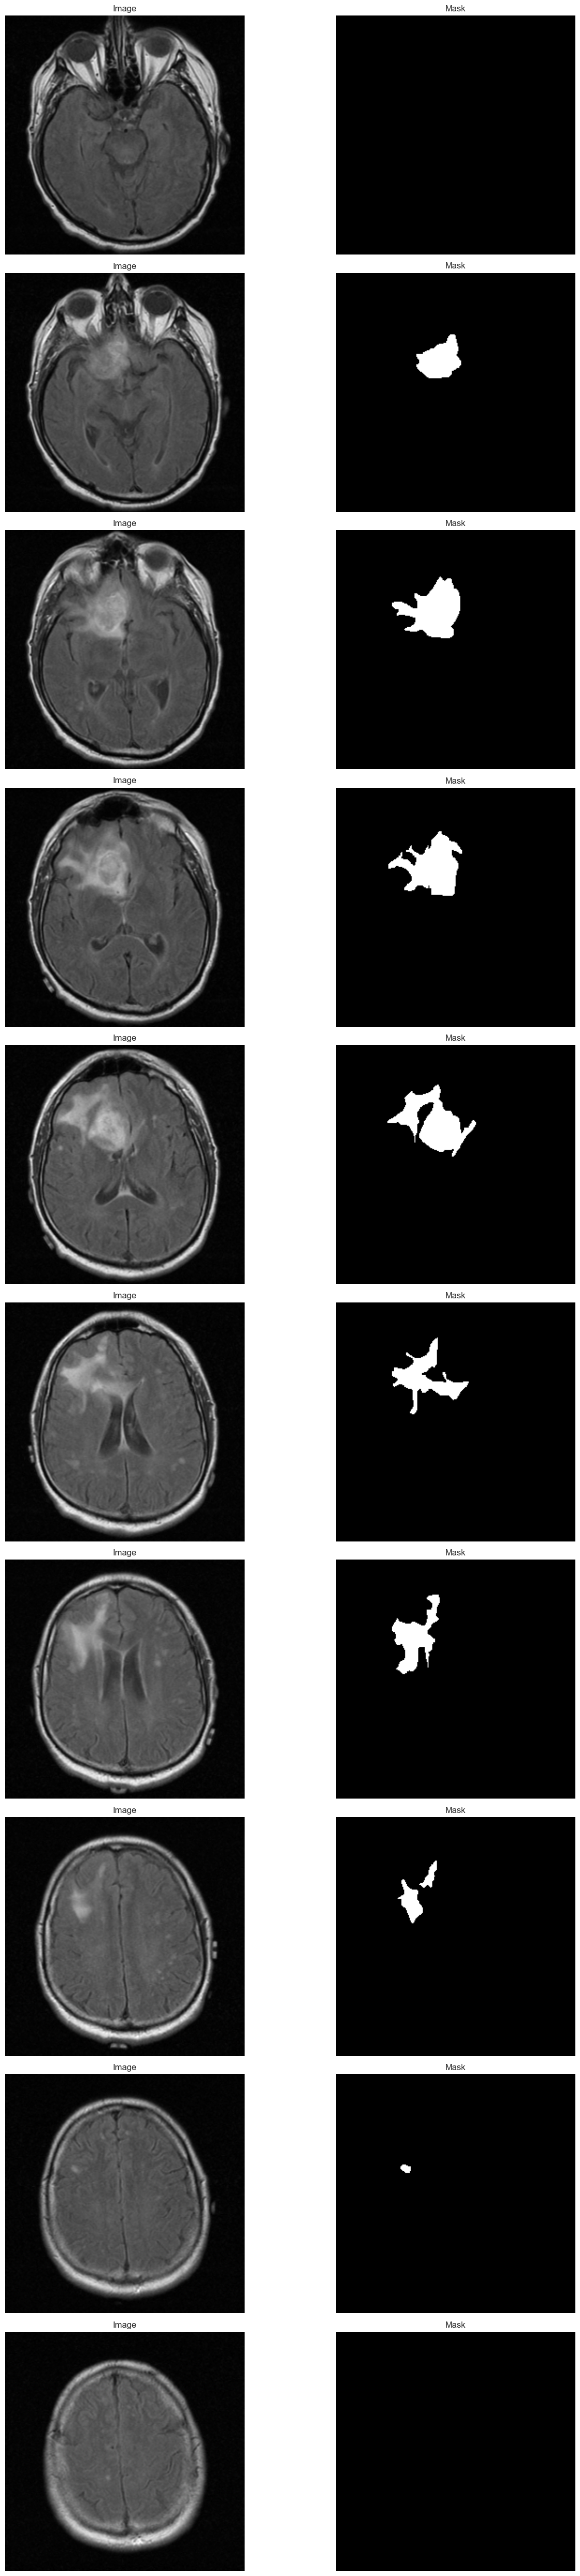

In [14]:
def plot_images(images, masks, num_images=10):
    # Create a figure with a specified size
    plt.figure(figsize=(15, num_images * 5))  # Width of 15 and height based on number of images
    
    for i in range(num_images):
        # Plot image
        plt.subplot(num_images, 2, 2 * i + 1)  # Arrange subplots in a grid with 2 columns
        plt.title('Image')  # Title for the image subplot
        plt.imshow(images[i].squeeze(), cmap='gray')  # Display image in grayscale
        plt.axis('off')  # Hide axis for a cleaner look
        
        # Plot mask
        plt.subplot(num_images, 2, 2 * i + 2)  # Position the mask subplot next to the image
        plt.title('Mask')  # Title for the mask subplot
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Display mask in grayscale
        plt.axis('off')  # Hide axis for a cleaner look
    
    plt.tight_layout()  # Adjust subplots to fit in the figure area
    plt.show()  # Display the figure

# Plot a specified number of images and masks
plot_images(images_array, masks_array, num_images=10)


# **splitting Data**

**This code splits the resized images and masks into training (70%) and testing (30%) sets. The train_test_split function from scikit-learn is used for this, with a fixed random_state to ensure consistent results across runs.**

In [15]:
#This code splits the resized images and masks into training (70%) and
#testing (30%) sets. The train_test_split function from scikit-learn is used for this, with a fixed
#random_state to ensure consistent results across runs.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(resized_images, resized_masks, test_size=0.4, random_state=42) # 60% train, 40% temp

**This code further splits the previously created test set into validation and test subsets. After the initial split, 50% of the remaining data (which was initially 30% of the full dataset) is used for validation and the other 50% for testing. As a result, the final dataset consists of 15% for validation and 15% for testing, with a fixed random_state for reproducibility.**

In [16]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42) # 15% test, 15% validation

In [17]:
print("training shape")
x_train.shape

training shape


(2357, 128, 128)

In [18]:
print("training shape")
x_test.shape

training shape


(786, 128, 128)

In [16]:
print("training shape")
x_val.shape

training shape


(786, 128, 128)

# **u_net**

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def unet_model_functional(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Contracting path
    conv1 = Conv2D(28, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(28, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(26, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.3)(pool2)

    conv3 = Conv2D(26, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.3)(pool4)

    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(pool4)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Dropout(0.5)(bottleneck)

    # Expansive path
    up5 = UpSampling2D((2, 2))(bottleneck)
    up5 = concatenate([up5, conv4], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    up6 = concatenate([up6, conv3], axis=-1)
    conv6 = Conv2D(26, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.3)(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    up7 = concatenate([up7, conv2], axis=-1)
    conv7 = Conv2D(26, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.3)(conv7)

    up8 = UpSampling2D((2, 2))(conv7)
    up8 = concatenate([up8, conv1], axis=-1)
    conv8 = Conv2D(28, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(28, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.3)(conv8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model



# **compile**

In [20]:
# Create the U-Net model
model = unet_model_functional(input_size=(128, 128, 1))


In [21]:
# Dice coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

# Dice coefficient loss
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# IOU function (Intersection over Union)
def iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [22]:
# Reshape the labels (y_train and y_val) to have the shape (batch_size, height, width, 1)
y_train = y_train.reshape((-1, 128, 128, 1))
y_val = y_val.reshape((-1, 128, 128, 1))

In [23]:

# Compile the model
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coefficient])

# **EARLY STOPPING**

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

In [25]:
history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=16, 
                    validation_data=(x_val, y_val),callbacks=[early_stopping])

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 71s 429ms/step - binary_accuracy: 0.7487 - dice_coefficient: 0.0702 - iou: 0.0370 - loss: 0.9299 - val_binary_accuracy: 0.0846 - val_dice_coefficient: 0.0222 - val_iou: 0.0113 - val_loss: 0.9774
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 60s 405ms/step - binary_accuracy: 0.9491 - dice_coefficient: 0.2006 - iou: 0.1147 - loss: 0.7994 - val_binary_accuracy: 0.8920 - val_dice_coefficient: 0.1094 - val_iou: 0.0594 - val_loss: 0.8887
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 57s 384ms/step - binary_accuracy: 0.9814 - dice_coefficient: 0.3202 - iou: 0.2023 - loss: 0.6798 - val_binary_accuracy: 0.9891 - val_dice_coefficient: 0.0012 - val_iou: 6.3182e-04 - val_loss: 0.9988
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 55s 374ms/step - binary_accuracy: 0.9884 - dice_coefficient: 0.4243 - iou: 0.2844 - loss: 0.5757 - val_binary_accuracy: 0.9828 - val_dice_coefficient: 0.3126 - val_iou: 0.1965 - val_loss: 0.6818
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 56s 377ms/s

# **Evaluate the Model:**

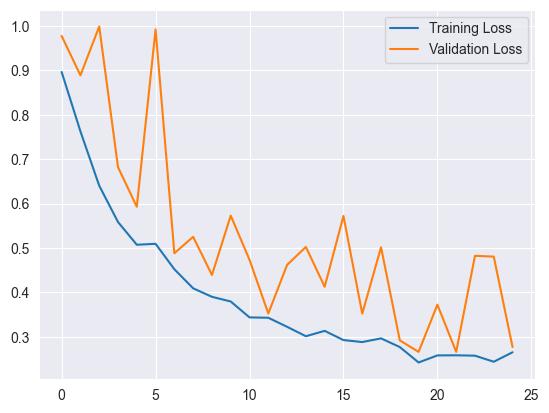

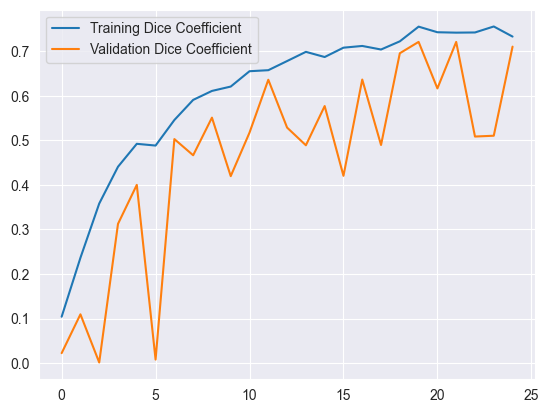

In [26]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot the Dice coefficient or IoU
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.show()


# **Visualize the Segmentation Results:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


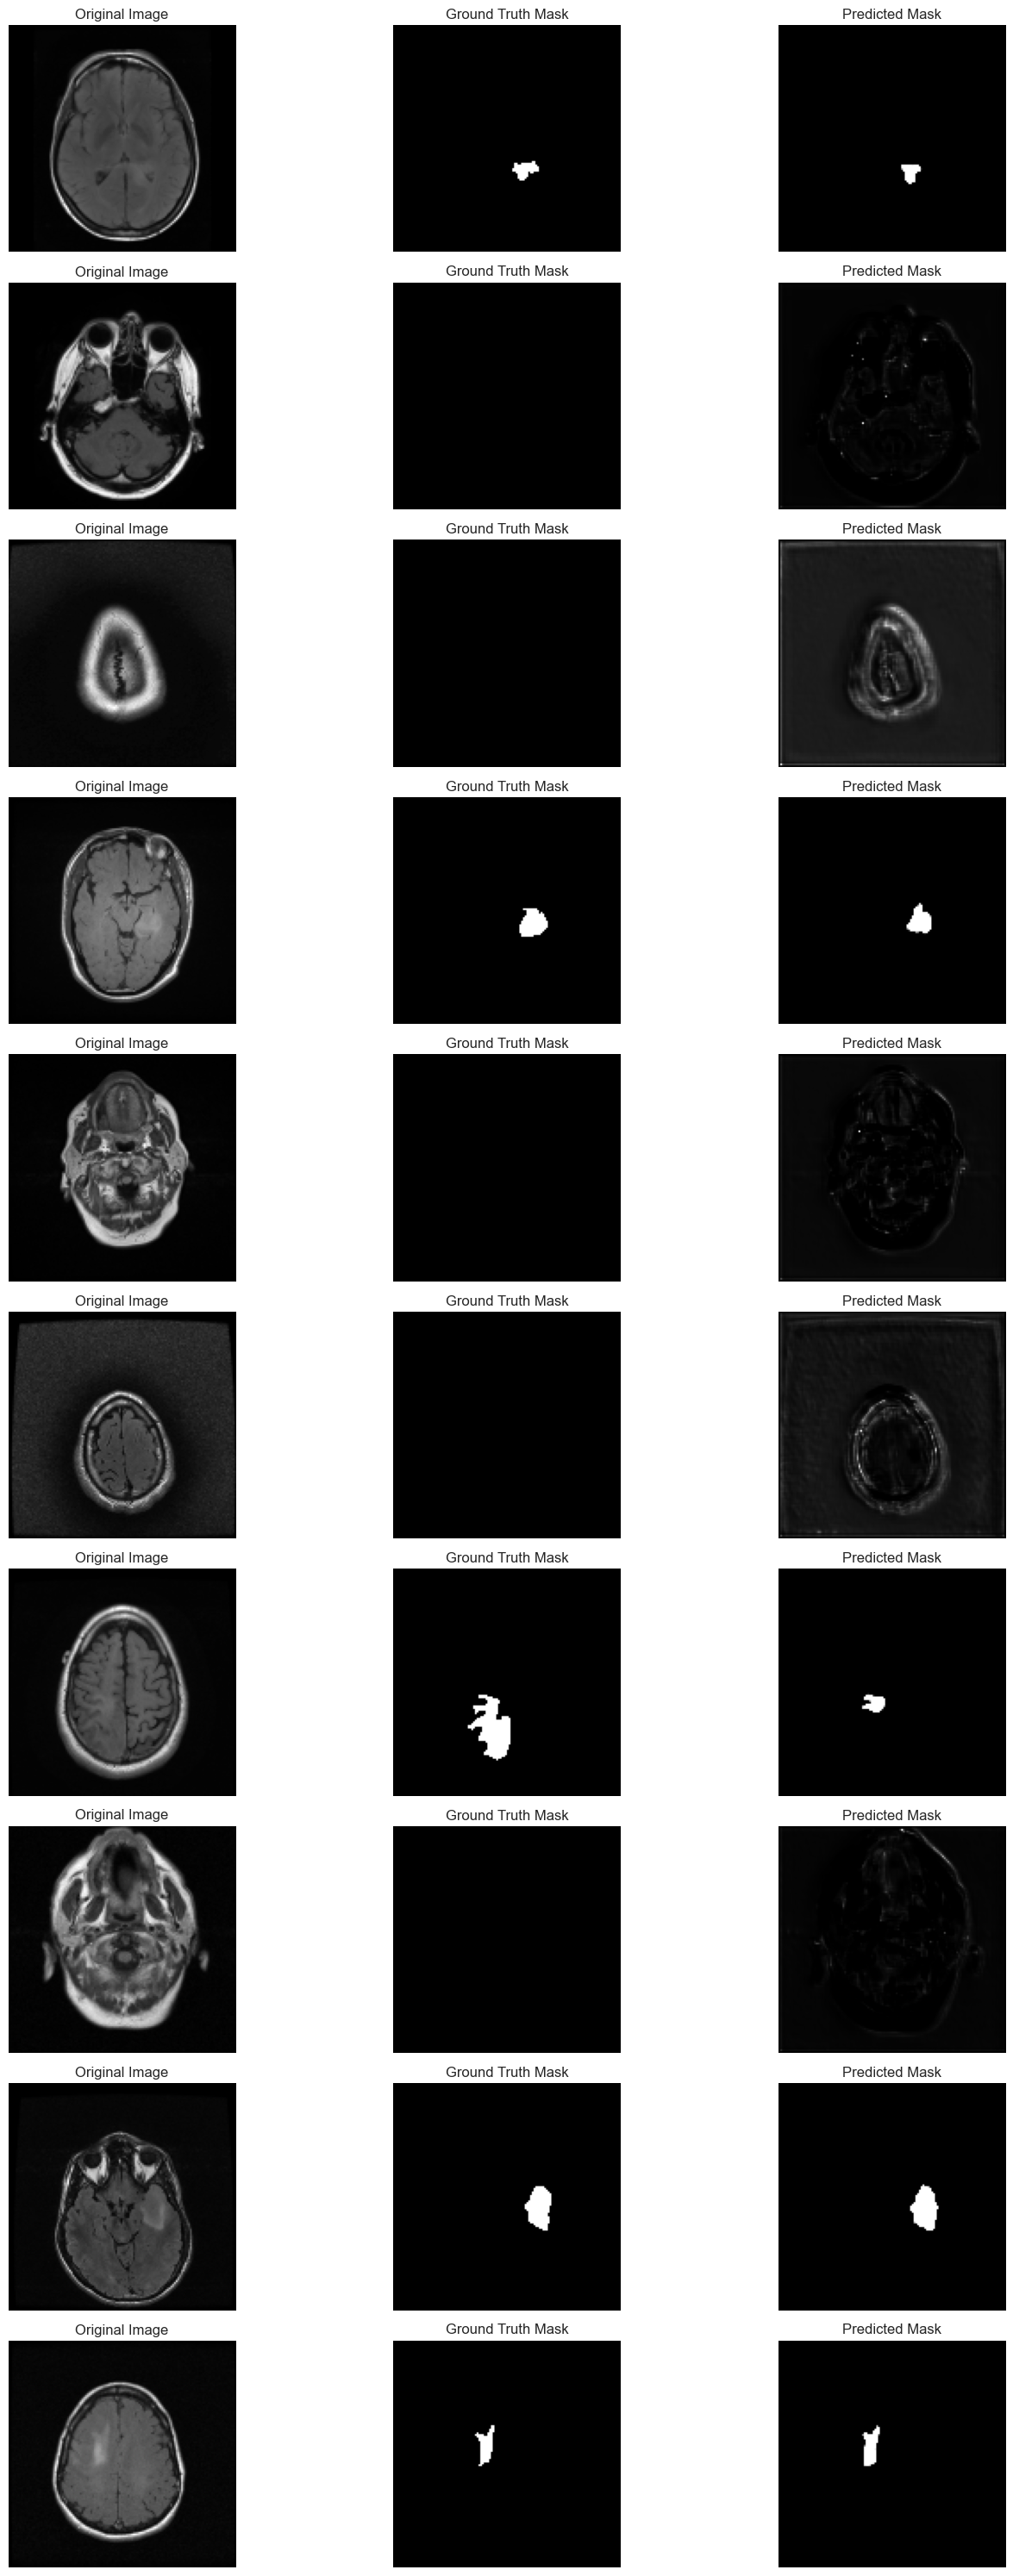

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Function to display original, ground truth, and predicted masks
def display_predictions(images, true_masks, predicted_masks, num_images=10):
    plt.figure(figsize=(15, num_images * 3))
    
    for i in range(num_images):
        # Original Image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # Ground Truth Mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_masks[i].reshape(128, 128), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(num_images, 3, i * 3 + 3)
        # Ensure the predicted mask is in the correct shape for visualization
        pred_mask = predicted_masks[i].reshape(128, 128) if len(predicted_masks.shape) == 4 else predicted_masks[i]
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Select 10 random images from the test set
num_images = 10
indices = np.random.choice(len(x_test), num_images, replace=False)  # Randomly select indices
x_test = x_test[indices]
y_test = y_test[indices]

# Predict masks for the selected images
predicted_masks = model.predict(x_test)

# Display the original images, true masks, and predicted masks
display_predictions(x_test, y_test, predicted_masks, num_images=num_images)
